In [ ]:
import pandas as pd
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

from matplotlib import cm
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.losses import SmoothPinballLoss
from model.model import LinearNet
from data.preprocessing import FrameTorch
from model.trainer import Trainer
from utils import get_scores

#### Import data

In [4]:
PATH_DATA = Path.cwd().parent / 'data' / 'files'

data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

#### PREPARE DATA

In [5]:
# intialize frametorch
frametorch = FrameTorch(data)
# split data
frametorch.split_data()
# scale data
frametorch.scale_data(method=MinMaxScaler)

# train, val and test loaders
train_loader, val_loader, test_loader = frametorch.data_to_loader()

### ONE MODEL, 8 OUTPUTS

In [6]:
# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = len(quantiles)

In [7]:
# model
quantilenet = LinearNet(n_inputs=n_inputs, n_outputs=n_outputs)
# criterion to use
criterion = SmoothPinballLoss(quantiles)
# optimizer
optimizer = optim.Adam(quantilenet.parameters(), lr=0.003)
# trainer class
trainer = Trainer(quantilenet, criterion, optimizer)

#### TRAIN DE MODEL

In [48]:
quantilenet = trainer.fit(train_loader, val_loader, epochs=1000, patience=100)

#### TRAINING CONVERGENCE

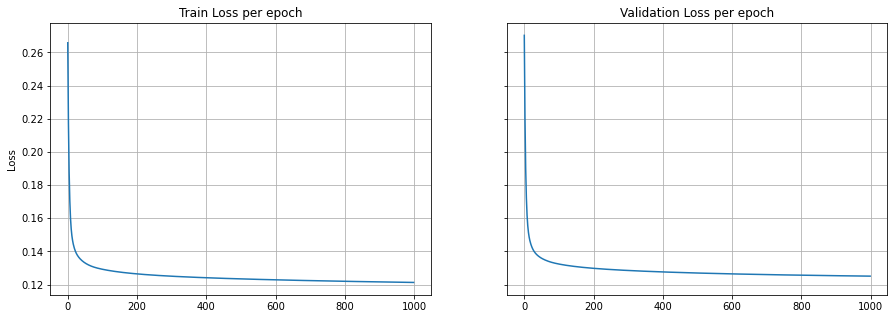

In [9]:
loss_ss = pd.Series(trainer.train_losses[1:])
validations_losses_ss = pd.Series(trainer.val_losses)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

loss_ss.plot(ax=ax[0])
validations_losses_ss.plot(ax=ax[1])
ax[0].set_ylabel('Loss')
ax[0].set_title('Train Loss per epoch')
ax[1].set_title('Validation Loss per epoch')
ax[0].grid()
ax[1].grid()

### 8 MODELS, ONE OUTPUT

In [20]:
# quantiles to predict
quantiles = torch.tensor([0.025, 0.05, 0.1, 0.15, 0.85, 0.9, 0.95, 0.975])

# number of inputs and outputs
n_inputs = frametorch.data.shape[1] - 1
n_outputs = 1

In [47]:
linear_models = []

for quantile in quantiles:
    # model
    linear_model = LinearNet(n_inputs=n_inputs, n_outputs=n_outputs)
    # criterion to use
    criterion = SmoothPinballLoss(quantile)
    # optimizer
    optimizer = optim.Adam(linear_model.parameters(), lr=0.003)
    # trainer class
    trainer = Trainer(linear_model, criterion, optimizer)

    # train
    linear_model = trainer.fit(train_loader, val_loader, epochs=1000, patience=100)
    linear_models.append(linear_model)

### VALIDATION PREDICTIONS 1 vs 8 MODELS

In [53]:
# validation input and target
inputs, target = frametorch.data_val[:, :-1], frametorch.data_val[:, -1:]
inputs = torch.tensor(inputs, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)
y_test = pd.Series(target.squeeze().tolist())

In [75]:
# quantilenet predictions
y_pred_quantilenet = quantilenet(inputs)
y_test = pd.Series(target.squeeze().tolist())
y_preds_quantilenet = pd.DataFrame(y_pred_quantilenet.tolist())

# linear predictions
y_preds_linear = []

for linear_model in linear_models:
    # predictions to pandas
    y_pred = linear_model(inputs)
    y_preds_linear.append(y_pred.squeeze().tolist())

y_preds_linear = pd.DataFrame(y_preds_linear).T
y_pred_linear = torch.tensor(y_preds_linear.values.tolist(), dtype=torch.float32)

### COMPARE MODEL TYPES

In [76]:
quantilenet_scores = get_scores(y_pred_quantilenet, target, quantiles)
linear_scores = get_scores(y_pred_linear, target, quantiles)

final_scores = pd.concat(
    [quantilenet_scores, linear_scores], axis=1, keys=['One model', 'Multiple models']
)
final_scores

,One model,Multiple models
QS,0.118472,0.118218
IS,29.049656,29.052456
Sharpnees,0.299643,0.302443
ACE,0.928941,1.224315


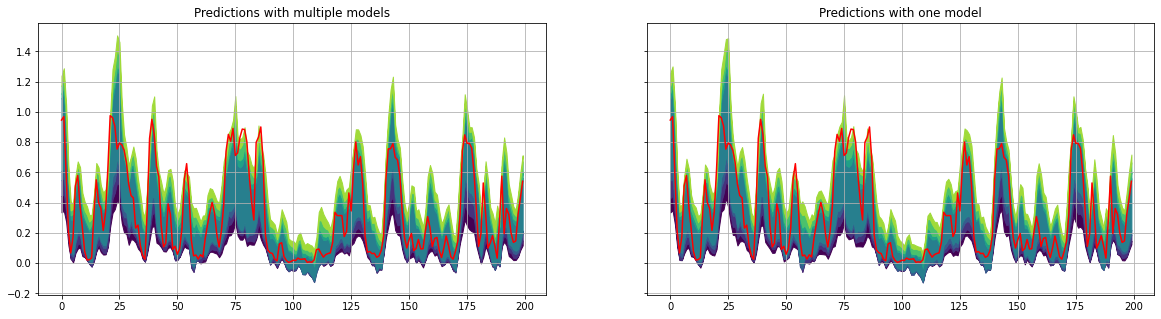

In [85]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)

for i in range(len(y_preds_linear.columns)-1):
    ax[0].fill_between(
        y_preds_linear.index[:200], 
        y_preds_linear[i][:200], 
        y_preds_linear[i+1][:200], 
        color=viridis.colors[i]
    )  
y_test[:200].plot(color='red', ax=ax[0])
ax[0].set_title('Predictions with multiple models')
ax[0].grid()

for i in range(len(y_preds_quantilenet.columns)-1):
    ax[1].fill_between(
        y_preds_quantilenet.index[:200], 
        y_preds_quantilenet[i][:200], 
        y_preds_quantilenet[i+1][:200], 
        color=viridis.colors[i]
    )
y_test[:200].plot(color='red', ax=ax[1])
ax[1].set_title('Predictions with one model')
ax[1].grid()